# Processing Sentiment Scores from Output Files

In [2]:
# Imports
import json
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

def calc_score(filename):
    score_file = f"./data/{filename}.json"
    with open(score_file, 'r') as f:
        raw_scores = json.load(f)

    scores = {'O': {'scores': []},
            'C': {'scores': []},
            'E': {'scores': []},
            'A': {'scores': []},
            'N': {'scores': []}
            }
    metadata = {}

    for question_number, question_dict in raw_scores.items():
        metadata[question_number] = {}
        responses = question_dict['responses']
        # Average across the responses first - store this as metadata
        avg_responses = []
        for response in responses:
            avg_responses.append(response['score'])
        avg = np.mean(avg_responses)
        std = np.std(avg_responses)
        metadata[question_number]['mean'] = avg
        metadata[question_number]['stdev'] = std

        # Append the average - change value depending on whether the response to this question should be positively or negative correlated with
        # the trait
        if response['reverse_score']:
            scores[response['domain']]['scores'].append(1 - avg)
        else:
            scores[response['domain']]['scores'].append(avg)

    for domain, score_dict in scores.items():
        # scores[domain]['scores'] = softmax(scores[domain]['scores'])
        #print(scores[domain]['scores'])
        scores[domain]['mean'] = np.mean(scores[domain]['scores'])
        scores[domain]['stdev'] = np.std(scores[domain]['scores'])
        del scores[domain]['scores']

    with open(f"./data/{filename}-scores.json", 'w') as f:
        json.dump(scores, f, indent=4)
    with open(f"./data/{filename}-metadata.json", 'w') as f:
        json.dump(metadata, f, indent=4)

files = ['gpt2-small', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']
for f in files:
    calc_score(f)

In [ ]:
# Plot results on a graph
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (15,10)
def plot_checkpoint_traits(model_name: str, score_dir: str):
    with open(score_dir, 'r') as f:
        scores = json.load(f)
    
    TRAITS = ['Openness', 'Conscientiousness', 'Extroversion', 'Agreeableness', 'Neuroticism']
    y_data = []
    y_err = []
    for trait in TRAITS:
        key = trait[0]
        y_data.append(scores[key]['mean'])
        y_err.append(scores[key]['stdev'])

    positions = np.arange(len(TRAITS))
    fig, ax = plt.subplots()
    ax.bar(positions, y_data, yerr=y_err, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel("Normalized Trait Alignment")
    ax.set_xticks(positions)
    ax.set_xticklabels(TRAITS)
    ax.set_ylim((min(y_data) - max(y_err) - 0.05, max(y_data) + max(y_err) + 0.05))
    ax.set_title(f"Big 5 Personality Traits of Checkpoint {model_name}")
    ax.yaxis.grid(True)

In [ ]:
plot_checkpoint_traits('gpt2', './data/gpt2-scores.json')

In [ ]:
plot_checkpoint_traits('gpt2-medium', './data/gpt2-medium-scores.json')

In [ ]:
plot_checkpoint_traits('gpt2-xl', './data/gpt2-xl-scores.json')

In [ ]:
plot_checkpoint_traits('gpt2-xl', './data/gpt2-test-scores.json')

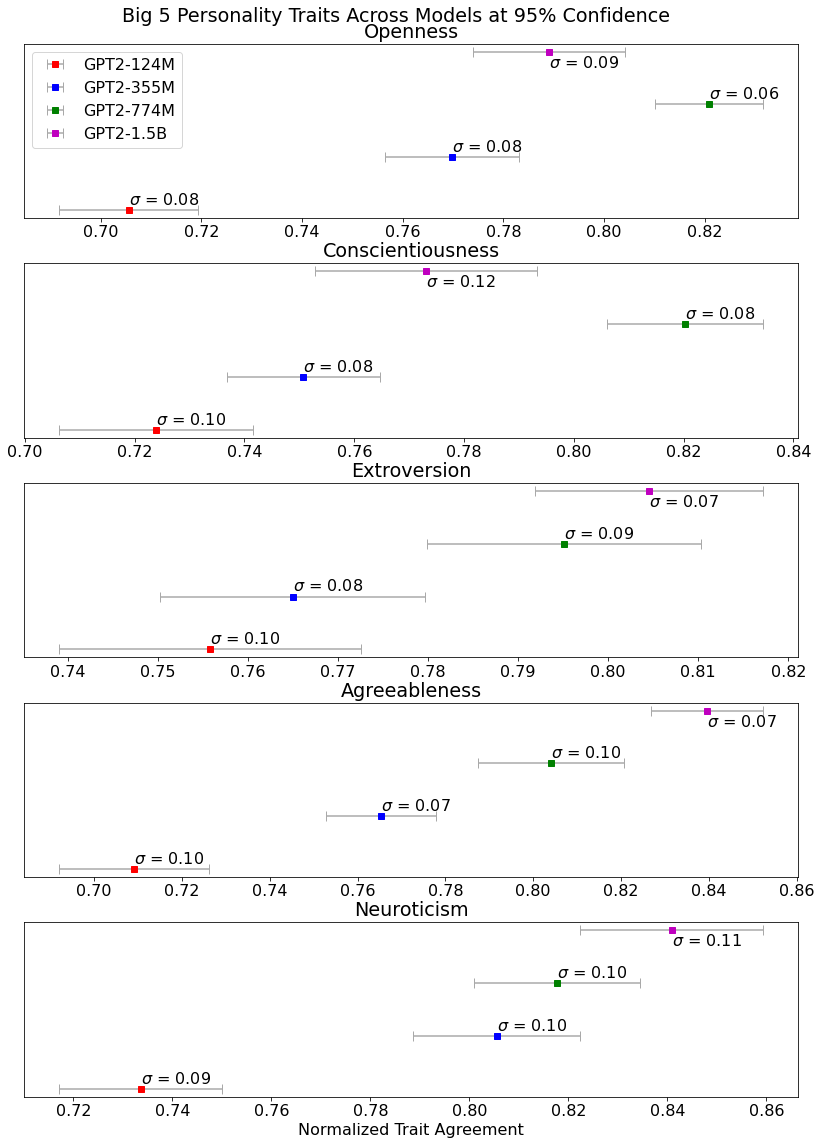

In [32]:
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (12,16)
def plot_aggregate():
    conf = 95
    z = 1.96

    file_dirs = ['gpt2-small-scores', 'gpt2-medium-scores', 'gpt2-large-scores', 'gpt2-xl-scores']
    models = ['GPT2-124M', 'GPT2-355M', 'GPT2-774M', 'GPT2-1.5B']
    TRAITS = ['Openness', 'Conscientiousness', 'Extroversion', 'Agreeableness', 'Neuroticism']
    formats = ['rs', 'bs', 'gs', 'ms']
    fig, axs = plt.subplots(5)
    fig.suptitle(f"Big 5 Personality Traits Across Models at {conf}% Confidence")
    fig.tight_layout()
    for i in range(len(TRAITS)):
        key = TRAITS[i][0]
        for j in range(len(file_dirs)):
            with open(f"./data/{file_dirs[j]}.json", 'r') as f:
                score_file = json.load(f)
            axs[i].errorbar(score_file[key]['mean'], 0.1*j, ecolor='darkgray', fmt=formats[j], xerr=z*score_file[key]['stdev']/np.sqrt(128), label=models[j], capsize=5)
            if j == len(file_dirs) - 1:
                axs[i].text(score_file[key]['mean'], 0.1*j - 0.03, f"$\sigma$ = {score_file[key]['stdev']:.2f}")
            else:
                axs[i].text(score_file[key]['mean'], 0.1*j + 0.01, f"$\sigma$ = {score_file[key]['stdev']:.2f}")
        axs[i].set_title(TRAITS[i])
        axs[i].set_yticks([])
        # axs[i].set_xlim((0, 1))
        if i == 0:
            axs[i].legend(loc="upper left")
    axs[len(axs)-1].set(xlabel='Normalized Trait Agreement')
plot_aggregate()